In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r"C:\Users\94718\OneDrive\Desktop\NIBM\AI\CourseWork\code\try2\Preprocessed"  # Local path
batch_size = 16     
num_classes = 4
epochs = 5          
learning_rate = 1e-2  


transform = transforms.Compose([
    transforms.Resize((64, 64)),  # smaller input than ResNet
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#cnn model
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, num_classes)  # 64x64 input → 32x32 after pooling

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = BaselineCNN(num_classes).to(device)

#loss optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#training
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {100*correct/total:.2f}%")

#eval
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Baseline Test Accuracy: {100*correct/total:.2f}%")


Epoch [1/5] Loss: 1.3148 Acc: 39.26%
Epoch [2/5] Loss: 1.0542 Acc: 57.42%
Epoch [3/5] Loss: 0.8372 Acc: 67.15%
Epoch [4/5] Loss: 0.7073 Acc: 72.66%
Epoch [5/5] Loss: 0.6187 Acc: 75.39%
Baseline Test Accuracy: 72.03%


Baseline Test Accuracy: 72.03%


<Figure size 800x600 with 0 Axes>

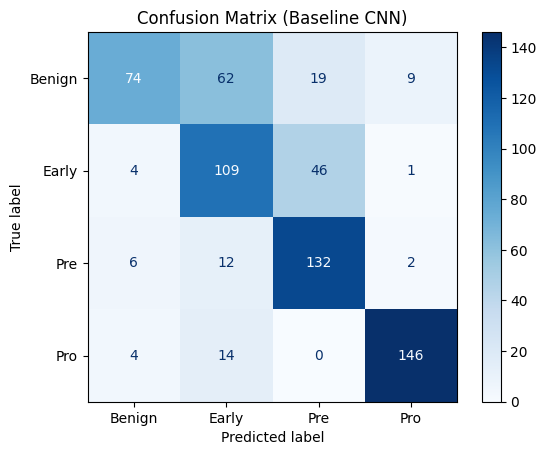

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# 6. Evaluation + Confusion Matrix
# -------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Baseline Test Accuracy: {100*acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes   # <-- make sure to keep this from earlier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (Baseline CNN)")
plt.show()
